In [9]:
import torch
print(torch.backends.mps.is_available())
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")

x = torch.ones((3, 3), device=device)
print(x.device)

True
mps:0


[Adam]  Epoch     0 | lr=1.00e-03 | Total:1.184e+04 | PDE:2.975e+01 | BC:2.362e+02
[Adam]  Epoch   500 | lr=9.94e-04 | Total:1.748e-01 | PDE:2.214e-02 | BC:3.053e-03
[Adam]  Epoch  1000 | lr=9.76e-04 | Total:8.778e-02 | PDE:1.091e-02 | BC:1.538e-03
[Adam]  Epoch  1500 | lr=9.46e-04 | Total:4.326e-02 | PDE:5.824e-03 | BC:7.488e-04
[Adam]  Epoch  2000 | lr=9.05e-04 | Total:2.112e-02 | PDE:2.946e-03 | BC:3.634e-04
[Adam]  Epoch  2500 | lr=8.55e-04 | Total:1.007e-02 | PDE:1.658e-03 | BC:1.683e-04
[Adam]  Epoch  3000 | lr=7.96e-04 | Total:4.560e-03 | PDE:1.064e-03 | BC:6.991e-05
[Adam]  Epoch  3500 | lr=7.30e-04 | Total:4.398e-01 | PDE:1.212e-03 | BC:8.773e-03
[Adam]  Epoch  4000 | lr=6.58e-04 | Total:5.323e-03 | PDE:8.241e-04 | BC:8.998e-05
[Adam]  Epoch  4500 | lr=5.82e-04 | Total:3.299e-03 | PDE:6.404e-04 | BC:5.317e-05
[Adam]  Epoch  5000 | lr=5.05e-04 | Total:1.969e-03 | PDE:4.705e-04 | BC:2.997e-05
[Adam]  Epoch  5500 | lr=4.27e-04 | Total:1.219e-03 | PDE:3.984e-04 | BC:1.641e-05
[Ada

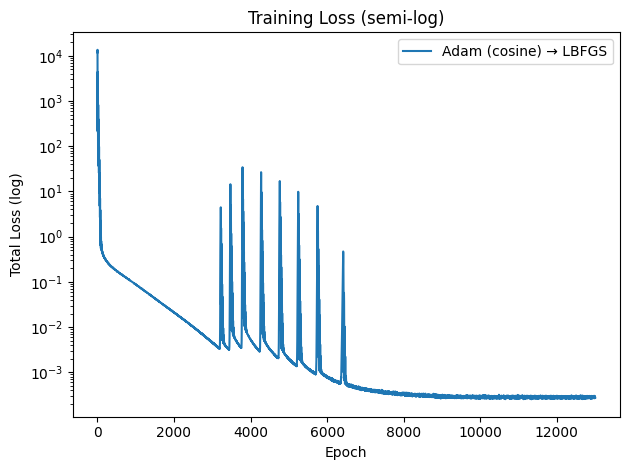

In [10]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.tri as mtri

# -------------------------
# Physical constants 
# -------------------------
L, W = 1.0, 0.5
lambda_  = 5.64e9
mu_T = 2.46e9
theta_deg = 30
mu_L = 5.66e9
alpha = 1.26e9
beta = 227.29e9
h = 1.0
sf = 1e9

# -------------------------
# Model 
# -------------------------
class PINN(nn.Module):
    def __init__(self):
        super(PINN, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(2, 128),
            nn.Softplus(beta=10),
            nn.Linear(128, 256),
            nn.Softplus(beta=10),
            nn.Linear(256, 256),
            nn.Softplus(beta=10),
            nn.Linear(256, 256),
            nn.Softplus(beta=10),
            nn.Linear(256, 6)
        )
    def forward(self, x, y):
        xi  = 2.0 * x / L
        eta = 2.0 * y / W
        return self.net(torch.cat([xi, eta], dim=1))


theta_rad = np.deg2rad(theta_deg)
c = torch.tensor(np.cos(theta_rad), dtype=torch.float32)
s = torch.tensor(np.sin(theta_rad), dtype=torch.float32)

def strain_tensor(u_net, v_net, x, y):
    u_x_true = torch.autograd.grad(u_net, x, torch.ones_like(u_net), retain_graph=True, create_graph=True)[0]
    u_y_true = torch.autograd.grad(u_net, y, torch.ones_like(u_net), retain_graph=True, create_graph=True)[0]
    v_x_true = torch.autograd.grad(v_net, x, torch.ones_like(v_net), retain_graph=True, create_graph=True)[0]
    v_y_true = torch.autograd.grad(v_net, y, torch.ones_like(v_net), retain_graph=True, create_graph=True)[0]
    Exx = u_x_true; Eyy = v_y_true; Exy = 0.5*(u_y_true + v_x_true)
    return u_x_true, u_y_true, v_x_true, v_y_true, Exx, Eyy, Exy

def stress_tensor(Exx, Eyy, Exy):
    trE = Exx + Eyy
    Ea_x = Exx * c + Exy * s
    Ea_y = Exy * c + Eyy * s
    aEa  = Exx*(c*c) + 2.0*Exy*(c*s) + Eyy*(s*s)

    t1_xx = trE * (lambda_ + alpha*(c*c))
    t1_xy = trE * (alpha * c * s)
    t1_yy = trE * (lambda_ + alpha*(s*s))

    t2_xx = 2.0 * mu_T * Exx
    t2_xy = 2.0 * mu_T * Exy
    t2_yy = 2.0 * mu_T * Eyy

    t3_xx = aEa * (alpha + beta*(c*c))
    t3_xy = aEa * (beta * c * s)
    t3_yy = aEa * (alpha + beta*(s*s))

    A_xx = 2.0 * c * Ea_x
    A_xy = c * Ea_y + Ea_x * s
    A_yy = 2.0 * s * Ea_y
    K = 2.0 * (mu_L - mu_T)
    t4_xx = K * A_xx
    t4_xy = K * A_xy
    t4_yy = K * A_yy

    sig_xx = t1_xx + t2_xx + t3_xx + t4_xx
    sig_xy = t1_xy + t2_xy + t3_xy + t4_xy
    sig_yy = t1_yy + t2_yy + t3_yy + t4_yy

    Sxx = h * sig_xx / sf
    Sxy = h * sig_xy / sf
    Syy = h * sig_yy / sf
    return Sxx, Syy, Sxy

def physics_loss(model, x, y):
    x.requires_grad_(True); y.requires_grad_(True)
    out = model(x, y)
    u_net, v_net, u_x_net, u_y_net, v_x_net, v_y_net = (out[:, i:i+1] for i in range(6))
    u_x_true, u_y_true, v_x_true, v_y_true, _, _, _ = strain_tensor(u_net, v_net, x, y)

    loss_grad = (
        torch.mean((u_x_net - u_x_true)**2) +
        torch.mean((u_y_net - u_y_true)**2) +
        torch.mean((v_x_net - v_x_true)**2) +
        torch.mean((v_y_net - v_y_true)**2)
    )

    Exx_net, Eyy_net = u_x_net, v_y_net
    Exy_net = 0.5 * (u_y_net + v_x_net)
    Sxx, Syy, Sxy = stress_tensor(Exx_net, Eyy_net, Exy_net)

    Sxx_x = torch.autograd.grad(Sxx, x, torch.ones_like(Sxx), retain_graph=True, create_graph=True)[0]
    Sxy_y = torch.autograd.grad(Sxy, y, torch.ones_like(Sxy), retain_graph=True, create_graph=True)[0]
    Syy_y = torch.autograd.grad(Syy, y, torch.ones_like(Syy), retain_graph=True, create_graph=True)[0]
    Sxy_x = torch.autograd.grad(Sxy, x, torch.ones_like(Sxy), retain_graph=True, create_graph=True)[0]

    rx = Sxx_x + Sxy_y
    ry = Syy_y + Sxy_x
    lpde = torch.mean(rx**2 + ry**2)
    return lpde + loss_grad

def boundary_condition_loss(model, L, W):
    y_A = torch.linspace(-W/2, W/2, 500).reshape(-1,1)
    x_A = -L/2 * torch.ones_like(y_A)
    out_A = model(x_A, y_A)
    u_A, v_A = out_A[:,0:1], out_A[:,1:2]
    loss_A = torch.mean(u_A**2 + v_A**2)

    x_D = L/2 * torch.ones_like(y_A)
    out_D = model(x_D, y_A) 
    u_D, v_D = out_D[:,2:3], out_D[:,3:4]   # gradients on D 
    loss_D = torch.mean((u_D - 0.02*L)**2 + v_D**2)

    x_C = torch.linspace(-L/2, L/2, 200).reshape(-1,1)
    y_C = -W/2 * torch.ones_like(x_C)
    out_C = model(x_C, y_C)
    Exx_C, Eyy_C = out_C[:,2:3], out_C[:,5:6]
    Exy_C = 0.5*(out_C[:,3:4] + out_C[:,4:5])
    _, Syy_C, Sxy_C = stress_tensor(Exx_C, Eyy_C, Exy_C)
    loss_C = torch.mean(Syy_C**2 + Sxy_C**2)

    y_B = W/2 * torch.ones_like(x_C)
    out_B = model(x_C, y_B)
    Exx_B, Eyy_B = out_B[:,2:3], out_B[:,5:6]
    Exy_B = 0.5*(out_B[:,3:4] + out_B[:,4:5])
    _, Syy_B, Sxy_B = stress_tensor(Exx_B, Eyy_B, Exy_B)
    loss_B = torch.mean(Syy_B**2 + Sxy_B**2)

    return loss_A + loss_D + loss_C + loss_B

def train_adam_with_scheduler(model, n_epochs, n_points, L, W, lr=1e-3, eta_min=1e-5):
    """Adam with cosine LR; returns loss history."""
    w_pde, w_bc = 1.0, 50.0
    opt = torch.optim.Adam(model.parameters(), lr=lr)
    sched = torch.optim.lr_scheduler.CosineAnnealingLR(opt, T_max=n_epochs, eta_min=eta_min)
    history = []
    for ep in range(n_epochs):
        x = torch.rand(n_points,1)*L - L/2
        y = torch.rand(n_points,1)*W - W/2
        lp = physics_loss(model, x, y)
        lb = boundary_condition_loss(model, L, W)
        loss = w_pde*lp + w_bc*lb
        opt.zero_grad(); loss.backward(); opt.step(); sched.step()
        history.append(loss.item())
        if ep % 500 == 0:
            print(f"[Adam]  Epoch {ep:5d} | lr={sched.get_last_lr()[0]:.2e} | Total:{loss.item():.3e} | PDE:{lp.item():.3e} | BC:{lb.item():.3e}")
    return history

def train_lbfgs_finetune(model, n_epochs, n_points, L, W, lr=1.0):
    """
    Lightweight LBFGS fine-tune: run n_epochs single-step LBFGS iterations 
    """
    w_pde, w_bc = 1.0, 50.0
    history = []
    for ep in range(n_epochs):
        opt = torch.optim.LBFGS(
            model.parameters(), lr=lr, max_iter=1,
            line_search_fn="strong_wolfe", history_size=100,
            tolerance_grad=1e-10, tolerance_change=1e-12
        )
        def closure():
            opt.zero_grad()
            x = torch.rand(n_points,1)*L - L/2
            y = torch.rand(n_points,1)*W - W/2
            lp = physics_loss(model, x, y)
            lb = boundary_condition_loss(model, L, W)
            loss = w_pde*lp + w_bc*lb
            loss.backward()
            return loss
        loss = opt.step(closure)
        history.append(loss.item())
        if ep % 200 == 0:
            print(f"[LBFGS] Epoch {ep:5d} | loss={loss.item():.3e}")
    return history

model = PINN()

ADAM_EPOCHS  = 10000  
LBFGS_EPOCHS = 3000
n_epochs = ADAM_EPOCHS + LBFGS_EPOCHS   # total stays 13k
n_points = 1000

adam_hist  = train_adam_with_scheduler(model, ADAM_EPOCHS,  n_points, L, W, lr=1e-3, eta_min=1e-5)
lbfgs_hist = train_lbfgs_finetune(model, LBFGS_EPOCHS, n_points, L, W, lr=1.0)

loss_history = adam_hist + lbfgs_hist  # combined


torch.save(model.state_dict(), "pinn_fiber_elasticity_new.pth")
print("✅ Model weights saved to pinn_fiber_elasticity_new.pth")

plt.figure()
iters = np.arange(1, len(loss_history)+1)
plt.semilogy(iters, loss_history, label="Adam (cosine) → LBFGS")
plt.xlabel("Epoch"); plt.ylabel("Total Loss (log)"); plt.title("Training Loss (semi-log)")
plt.legend(); plt.tight_layout(); plt.show()


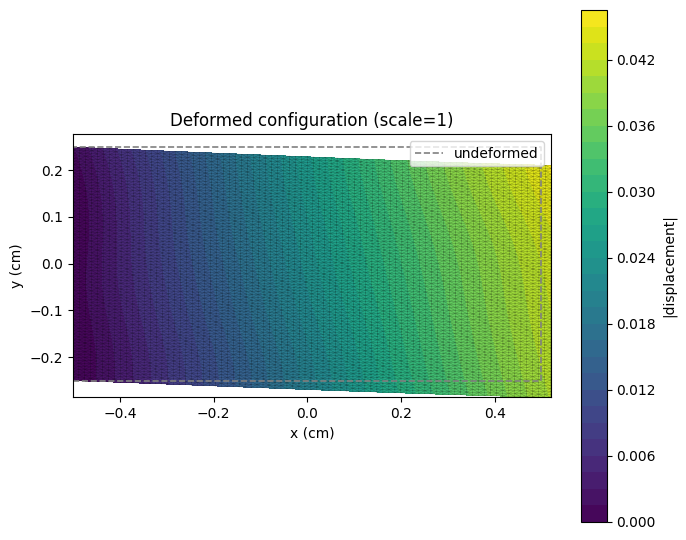

In [11]:
import matplotlib.pyplot as plt
import matplotlib.tri as mtri
import numpy as np
import torch

@torch.no_grad()
def plot_deformed_configuration(model, L, W, n_per_side=81, scale=1.0, cmap="viridis"):
    model.eval()
    device = next(model.parameters()).device

    # Build a uniform grid over the plate
    xs = torch.linspace(-L/2, L/2, n_per_side, device=device)
    ys = torch.linspace(-W/2, W/2, n_per_side, device=device)
    Xg, Yg = torch.meshgrid(xs, ys, indexing="xy")
    x = Xg.reshape(-1, 1)
    y = Yg.reshape(-1, 1)

    # Predict [u, v] with the PINN
    out = model(x, y)
    u = out[:, 0:1]
    v = out[:, 1:2]

    # Deformed coordinates (amplified by 'scale' for visibility)
    x_def = (x + scale * u).detach().cpu().numpy().ravel()
    y_def = (y + scale * v).detach().cpu().numpy().ravel()

    # Undeformed for reference
    x_und = x.detach().cpu().numpy().ravel()
    y_und = y.detach().cpu().numpy().ravel()

    # Triangulate the (regular) grid for a nicer surface plot
    tri = mtri.Triangulation(x_und, y_und)

    # Displacement magnitude for coloring
    disp_mag = torch.sqrt(u**2 + v**2).detach().cpu().numpy().ravel()

    # Plot
    plt.figure(figsize=(7, 5.5))
    tpc = plt.tricontourf(x_def, y_def, tri.triangles, disp_mag, levels=30, cmap=cmap)
    plt.colorbar(tpc, label="|displacement|")
    # draw deformed mesh lines
    plt.triplot(x_def, y_def, tri.triangles, lw=0.3, color="k", alpha=0.35)

    # outline of undeformed boundary for reference
    plt.plot([ -L/2,  L/2,  L/2, -L/2, -L/2 ],
             [ -W/2, -W/2,  W/2,  W/2, -W/2 ], ls="--", lw=1.2, color="gray", label="undeformed")

    plt.gca().set_aspect("equal", adjustable="box")
    plt.xlabel("x (cm)"); plt.ylabel("y (cm)")
    plt.title(f"Deformed configuration (scale={scale:g})")
    plt.legend(loc="upper right")
    plt.tight_layout()
    plt.show()

plot_deformed_configuration(model, L, W, n_per_side=81, scale=1.0)


[Adam]  Epoch     0 | lr=1.00e-03 | Total:3.342e+03 | PDE:5.047e+00 | BC:6.674e+01
[Adam]  Epoch   500 | lr=9.94e-04 | Total:2.761e-02 | PDE:1.982e-02 | BC:1.559e-04
[Adam]  Epoch  1000 | lr=9.75e-04 | Total:9.443e-03 | PDE:6.564e-03 | BC:5.758e-05
[Adam]  Epoch  1500 | lr=9.45e-04 | Total:5.673e-03 | PDE:4.045e-03 | BC:3.256e-05
[Adam]  Epoch  2000 | lr=9.04e-04 | Total:3.444e-03 | PDE:2.338e-03 | BC:2.211e-05
[Adam]  Epoch  2500 | lr=8.53e-04 | Total:2.218e-03 | PDE:1.479e-03 | BC:1.479e-05
[Adam]  Epoch  3000 | lr=7.94e-04 | Total:1.498e-03 | PDE:1.031e-03 | BC:9.328e-06
[Adam]  Epoch  3500 | lr=7.27e-04 | Total:1.168e-03 | PDE:8.760e-04 | BC:5.832e-06
[Adam]  Epoch  4000 | lr=6.54e-04 | Total:8.990e-04 | PDE:7.187e-04 | BC:3.607e-06
[Adam]  Epoch  4500 | lr=5.78e-04 | Total:7.273e-04 | PDE:6.050e-04 | BC:2.447e-06
[Adam]  Epoch  5000 | lr=5.00e-04 | Total:5.758e-04 | PDE:4.859e-04 | BC:1.797e-06
[Adam]  Epoch  5500 | lr=4.22e-04 | Total:5.258e-04 | PDE:4.508e-04 | BC:1.499e-06
[Ada

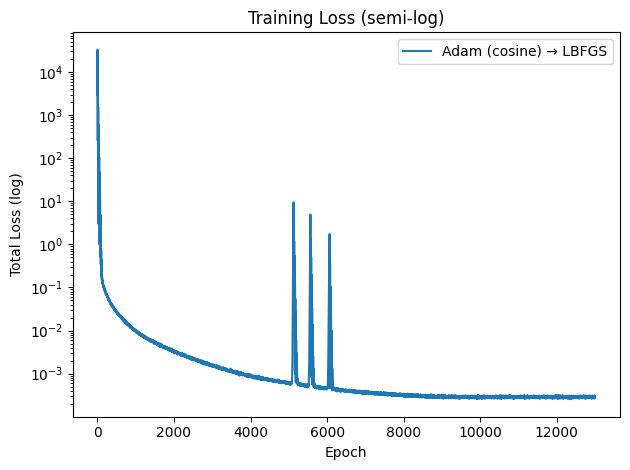

In [12]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.tri as mtri

# -------------------------
# Physical constants 
# -------------------------
L, W = 1.0, 0.5
lambda_  = 5.64e9
mu_T = 2.46e9
theta_deg = 30
mu_L = 5.66e9
alpha = 1.26e9
beta = 227.29e9
h = 1.0
sf = 1e9

# -------------------------
# Model
# -------------------------
class PINN(nn.Module):
    def __init__(self):
        super(PINN, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(2, 128),
            nn.Softplus(beta=10),
            nn.Linear(128, 256),
            nn.Softplus(beta=10),
            nn.Linear(256, 256),
            nn.Softplus(beta=10),
            nn.Linear(256, 256),
            nn.Softplus(beta=10),
            nn.Linear(256, 6)
        )
    def forward(self, x, y):
        xi  = 2.0 * x / L
        eta = 2.0 * y / W
        return self.net(torch.cat([xi, eta], dim=1))


theta_rad = np.deg2rad(theta_deg)
c = torch.tensor(np.cos(theta_rad), dtype=torch.float32)
s = torch.tensor(np.sin(theta_rad), dtype=torch.float32)

def strain_tensor(u_net, v_net, x, y):
    u_x_true = torch.autograd.grad(u_net, x, torch.ones_like(u_net), retain_graph=True, create_graph=True)[0]
    u_y_true = torch.autograd.grad(u_net, y, torch.ones_like(u_net), retain_graph=True, create_graph=True)[0]
    v_x_true = torch.autograd.grad(v_net, x, torch.ones_like(v_net), retain_graph=True, create_graph=True)[0]
    v_y_true = torch.autograd.grad(v_net, y, torch.ones_like(v_net), retain_graph=True, create_graph=True)[0]
    Exx = u_x_true; Eyy = v_y_true; Exy = 0.5*(u_y_true + v_x_true)
    return u_x_true, u_y_true, v_x_true, v_y_true, Exx, Eyy, Exy

def stress_tensor(Exx, Eyy, Exy):
    trE = Exx + Eyy
    Ea_x = Exx * c + Exy * s
    Ea_y = Exy * c + Eyy * s
    aEa  = Exx*(c*c) + 2.0*Exy*(c*s) + Eyy*(s*s)

    t1_xx = trE * (lambda_ + alpha*(c*c))
    t1_xy = trE * (alpha * c * s)
    t1_yy = trE * (lambda_ + alpha*(s*s))

    t2_xx = 2.0 * mu_T * Exx
    t2_xy = 2.0 * mu_T * Exy
    t2_yy = 2.0 * mu_T * Eyy

    t3_xx = aEa * (alpha + beta*(c*c))
    t3_xy = aEa * (beta * c * s)
    t3_yy = aEa * (alpha + beta*(s*s))

    A_xx = 2.0 * c * Ea_x
    A_xy = c * Ea_y + Ea_x * s
    A_yy = 2.0 * s * Ea_y
    K = 2.0 * (mu_L - mu_T)
    t4_xx = K * A_xx
    t4_xy = K * A_xy
    t4_yy = K * A_yy

    sig_xx = t1_xx + t2_xx + t3_xx + t4_xx
    sig_xy = t1_xy + t2_xy + t3_xy + t4_xy
    sig_yy = t1_yy + t2_yy + t3_yy + t4_yy

    Sxx = h * sig_xx / sf
    Sxy = h * sig_xy / sf
    Syy = h * sig_yy / sf
    return Sxx, Syy, Sxy

def physics_loss(model, x, y):
    x.requires_grad_(True); y.requires_grad_(True)
    out = model(x, y)
    u_net, v_net, u_x_net, u_y_net, v_x_net, v_y_net = (out[:, i:i+1] for i in range(6))
    u_x_true, u_y_true, v_x_true, v_y_true, _, _, _ = strain_tensor(u_net, v_net, x, y)

    loss_grad = (
        torch.mean((u_x_net - u_x_true)**2) +
        torch.mean((u_y_net - u_y_true)**2) +
        torch.mean((v_x_net - v_x_true)**2) +
        torch.mean((v_y_net - v_y_true)**2)
    )

    Exx_net, Eyy_net = u_x_net, v_y_net
    Exy_net = 0.5 * (u_y_net + v_x_net)
    Sxx, Syy, Sxy = stress_tensor(Exx_net, Eyy_net, Exy_net)

    Sxx_x = torch.autograd.grad(Sxx, x, torch.ones_like(Sxx), retain_graph=True, create_graph=True)[0]
    Sxy_y = torch.autograd.grad(Sxy, y, torch.ones_like(Sxy), retain_graph=True, create_graph=True)[0]
    Syy_y = torch.autograd.grad(Syy, y, torch.ones_like(Syy), retain_graph=True, create_graph=True)[0]
    Sxy_x = torch.autograd.grad(Sxy, x, torch.ones_like(Sxy), retain_graph=True, create_graph=True)[0]

    rx = Sxx_x + Sxy_y
    ry = Syy_y + Sxy_x
    lpde = torch.mean(rx**2 + ry**2)
    return lpde + loss_grad

def boundary_condition_loss(model, L, W):
    y_A = torch.linspace(-W/2, W/2, 500).reshape(-1,1)
    x_A = -L/2 * torch.ones_like(y_A)
    out_A = model(x_A, y_A)
    u_A, v_A = out_A[:,0:1], out_A[:,1:2]
    loss_A = torch.mean(u_A**2 + v_A**2)

    EPS0 = 0.02
    LOAD_SIGN = -1.0

    x_D =  L/2 * torch.ones_like(y_A)
    out_D = model(x_D, y_A)

    u_x_D = out_D[:,2:3]   # ε_xx
    loss_D_strain = torch.mean((u_x_D - LOAD_SIGN*EPS0)**2)
    
    Exx_D, Eyy_D = out_D[:,2:3], out_D[:,5:6]
    Exy_D = 0.5*(out_D[:,3:4] + out_D[:,4:5])
    _, _, Sxy_D = stress_tensor(Exx_D, Eyy_D, Exy_D)
    loss_D = loss_D_strain + 0.1*torch.mean(Sxy_D**2)    

    x_C = torch.linspace(-L/2, L/2, 200).reshape(-1,1)
    y_C = -W/2 * torch.ones_like(x_C)
    out_C = model(x_C, y_C)
    Exx_C, Eyy_C = out_C[:,2:3], out_C[:,5:6]
    Exy_C = 0.5*(out_C[:,3:4] + out_C[:,4:5])
    _, Syy_C, Sxy_C = stress_tensor(Exx_C, Eyy_C, Exy_C)
    loss_C = torch.mean(Syy_C**2 + Sxy_C**2)

    y_B = W/2 * torch.ones_like(x_C)
    out_B = model(x_C, y_B)
    Exx_B, Eyy_B = out_B[:,2:3], out_B[:,5:6]
    Exy_B = 0.5*(out_B[:,3:4] + out_B[:,4:5])
    _, Syy_B, Sxy_B = stress_tensor(Exx_B, Eyy_B, Exy_B)
    loss_B = torch.mean(Syy_B**2 + Sxy_B**2)

    return loss_A + loss_D + loss_C + loss_B

def train_adam_with_scheduler(model, n_epochs, n_points, L, W, lr=1e-3, eta_min=1e-5):
    """Adam with cosine LR; returns loss history."""
    w_pde, w_bc = 1.0, 50.0
    opt = torch.optim.Adam(model.parameters(), lr=lr)
    sched = torch.optim.lr_scheduler.CosineAnnealingLR(opt, T_max=n_epochs, eta_min=eta_min)
    history = []
    for ep in range(n_epochs):
        x = torch.rand(n_points,1)*L - L/2
        y = torch.rand(n_points,1)*W - W/2
        lp = physics_loss(model, x, y)
        lb = boundary_condition_loss(model, L, W)
        loss = w_pde*lp + w_bc*lb
        opt.zero_grad(); loss.backward(); opt.step(); sched.step()
        history.append(loss.item())
        if ep % 500 == 0:
            print(f"[Adam]  Epoch {ep:5d} | lr={sched.get_last_lr()[0]:.2e} | Total:{loss.item():.3e} | PDE:{lp.item():.3e} | BC:{lb.item():.3e}")
    return history

def train_lbfgs_finetune(model, n_epochs, n_points, L, W, lr=1.0):
    """
    Lightweight LBFGS fine-tune: run n_epochs single-step LBFGS iterations 
    """
    w_pde, w_bc = 1.0, 50.0
    history = []
    for ep in range(n_epochs):
        opt = torch.optim.LBFGS(
            model.parameters(), lr=lr, max_iter=1,
            line_search_fn="strong_wolfe", history_size=100,
            tolerance_grad=1e-10, tolerance_change=1e-12
        )
        def closure():
            opt.zero_grad()
            x = torch.rand(n_points,1)*L - L/2
            y = torch.rand(n_points,1)*W - W/2
            lp = physics_loss(model, x, y)
            lb = boundary_condition_loss(model, L, W)
            loss = w_pde*lp + w_bc*lb
            loss.backward()
            return loss
        loss = opt.step(closure)
        history.append(loss.item())
        if ep % 200 == 0:
            print(f"[LBFGS] Epoch {ep:5d} | loss={loss.item():.3e}")
    return history

model_compression = PINN()

ADAM_EPOCHS  = 10000 
LBFGS_EPOCHS = 3000
n_epochs = ADAM_EPOCHS + LBFGS_EPOCHS   # total stays 13k
n_points = 1000

adam_hist  = train_adam_with_scheduler(model_compression, ADAM_EPOCHS,  n_points, L, W, lr=1e-3, eta_min=1e-7)
lbfgs_hist = train_lbfgs_finetune(model_compression, LBFGS_EPOCHS, n_points, L, W, lr=1.0)

loss_history = adam_hist + lbfgs_hist  # combined


torch.save(model_compression.state_dict(), "pinn_fiber_elasticity_compression.pth")
print("✅ Model weights saved to pinn_fiber_elasticity_compression.pth")

plt.figure()
iters = np.arange(1, len(loss_history)+1)
plt.semilogy(iters, loss_history, label="Adam (cosine) → LBFGS")
plt.xlabel("Epoch"); plt.ylabel("Total Loss (log)"); plt.title("Training Loss (semi-log)")
plt.legend(); plt.tight_layout(); plt.show()


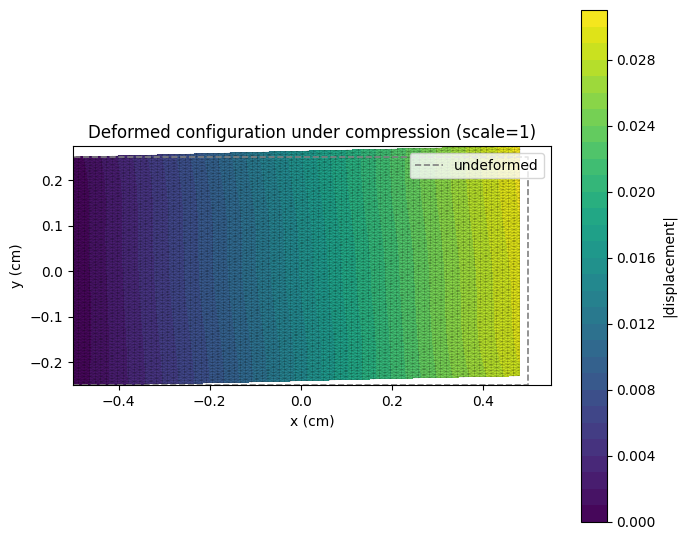

In [13]:
import matplotlib.pyplot as plt
import matplotlib.tri as mtri
import numpy as np
import torch

@torch.no_grad()
def plot_deformed_configuration(model, L, W, n_per_side=81, scale=1.0, cmap="viridis"):
    model_compression.eval()
    device = next(model_compression.parameters()).device

    # Build a uniform grid over the plate
    xs = torch.linspace(-L/2, L/2, n_per_side, device=device)
    ys = torch.linspace(-W/2, W/2, n_per_side, device=device)
    Xg, Yg = torch.meshgrid(xs, ys, indexing="xy")
    x = Xg.reshape(-1, 1)
    y = Yg.reshape(-1, 1)

    # Predict [u, v] with the PINN
    out = model_compression(x, y)
    u = out[:, 0:1]
    v = out[:, 1:2]

    # Deformed coordinates (amplified by 'scale' for visibility)
    x_def = (x + scale * u).detach().cpu().numpy().ravel()
    y_def = (y + scale * v).detach().cpu().numpy().ravel()

    # Undeformed for reference
    x_und = x.detach().cpu().numpy().ravel()
    y_und = y.detach().cpu().numpy().ravel()

    # Triangulate the (regular) grid for a nicer surface plot
    tri = mtri.Triangulation(x_und, y_und)

    # Displacement magnitude for coloring
    disp_mag = torch.sqrt(u**2 + v**2).detach().cpu().numpy().ravel()

    # Plot
    plt.figure(figsize=(7, 5.5))
    tpc = plt.tricontourf(x_def, y_def, tri.triangles, disp_mag, levels=30, cmap=cmap)
    plt.colorbar(tpc, label="|displacement|")
    # draw deformed mesh lines
    plt.triplot(x_def, y_def, tri.triangles, lw=0.3, color="k", alpha=0.35)

    # outline of undeformed boundary for reference
    plt.plot([ -L/2,  L/2,  L/2, -L/2, -L/2 ],
             [ -W/2, -W/2,  W/2,  W/2, -W/2 ], ls="--", lw=1.2, color="gray", label="undeformed")

    plt.gca().set_aspect("equal", adjustable="box")
    plt.xlabel("x (cm)"); plt.ylabel("y (cm)")
    plt.title(f"Deformed configuration under compression (scale={scale:g})")
    plt.legend(loc="upper right")
    plt.tight_layout()
    plt.show()

plot_deformed_configuration(model_compression, L, W, n_per_side=81, scale=1.0)


In [15]:
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
import math


L, W = 1.0, 0.5  # geometry (cm)

# ---------- Load COMSOL CSV ----------
def load_comsol_csv(path):
    header_fields = None
    with open(path, "r", encoding="utf-8", errors="ignore") as f:
        for line in f:
            if line.startswith("% X,"):
                header_fields = line.strip()[2:].split(",")
                break
    if header_fields is None:
        raise RuntimeError("Could not find '% X,' header in COMSOL CSV.")
    df = pd.read_csv(path, comment="%", header=None, names=header_fields, engine="python")
    df.columns = [c.strip() for c in df.columns]
    for c in df.columns:
        df[c] = pd.to_numeric(df[c], errors="coerce")
    return df.dropna(how="all").reset_index(drop=True)

# ---------- Define PINN ----------
class PINN(nn.Module):
    def __init__(self):
        super(PINN, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(2, 128),
            nn.Softplus(beta=10),
            nn.Linear(128, 256),
            nn.Softplus(beta=10),
            nn.Linear(256, 256),
            nn.Softplus(beta=10),
            nn.Linear(256, 256),
            nn.Softplus(beta=10),
            nn.Linear(256, 6)
        )
    def forward(self, x, y):
        xi = 2.0 * x / L
        eta = 2.0 * y / W
        return self.net(torch.cat([xi, eta], dim=1))

# ---------- Compute error metrics ----------
def compute_errors(model, df):
    device = torch.device("cpu")
    model.to(device)
    model.eval()

    x = torch.tensor(df["x (cm)"].values, dtype=torch.float32).reshape(-1,1).to(device)
    y = torch.tensor(df["y (cm)"].values, dtype=torch.float32).reshape(-1,1).to(device)

    with torch.no_grad():
        out = model(x, y)
    u_pred = out[:,0].cpu().numpy()
    v_pred = out[:,1].cpu().numpy()

    u_true = df["u1 (cm)"].values
    v_true = df["u2 (cm)"].values

    # total MSE (u + v combined)
    total_mse = np.mean((u_pred - u_true)**2 + (v_pred - v_true)**2)

    # relative L2 errors
    rel_L2_u = np.linalg.norm(u_pred - u_true) / np.linalg.norm(u_true)
    rel_L2_v = np.linalg.norm(v_pred - v_true) / np.linalg.norm(v_true)

    return total_mse, rel_L2_u, rel_L2_v

# ---------- Main comparison ----------
if __name__ == "__main__":
    # Paths to data
    csv_tension = '/Users/murat/Downloads/For Murat/Percentage 0.025.csv'       # COMSOL tension file
    csv_compression = '/Users/murat/Downloads/For Murat/Percentage -0.025.csv'    # COMSOL compression file
    pth_tension = "pinn_fiber_elasticity_new.pth"
    pth_compression = "pinn_fiber_elasticity_compression.pth"

    # Load data
    df_tension = load_comsol_csv(csv_tension)
    df_compression = load_comsol_csv(csv_compression)

    # Initialize models
    model_tension = PINN()
    model_compression = PINN()
    model_tension.load_state_dict(torch.load(pth_tension, map_location="cpu"))
    model_compression.load_state_dict(torch.load(pth_compression, map_location="cpu"))

    # Compute metrics
    mse_ten, L2u_ten, L2v_ten = compute_errors(model_tension, df_tension)
    mse_comp, L2u_comp, L2v_comp = compute_errors(model_compression, df_compression)

    print("=== RESULTS ===")
    print("→ Tension case:")
    print(f"   Total MSE:        {mse_ten:.6e}")
    print(f"   Rel. L2 (u_x):    {L2u_ten:.6e}")
    print(f"   Rel. L2 (u_y):    {L2v_ten:.6e}")

    print("\n→ Compression case:")
    print(f"   Total MSE:        {mse_comp:.6e}")
    print(f"   Rel. L2 (u_x):    {L2u_comp:.6e}")
    print(f"   Rel. L2 (u_y):    {L2v_comp:.6e}")


=== RESULTS ===
→ Tension case:
   Total MSE:        6.034880e-04
   Rel. L2 (u_x):    3.994646e-01
   Rel. L2 (u_y):    8.040932e+00

→ Compression case:
   Total MSE:        2.128120e-04
   Rel. L2 (u_x):    3.193003e-01
   Rel. L2 (u_y):    4.648569e+00


/var/folders/pt/b943j30n03g51nn4mmps3krc0000gp/T/ipykernel_53492/483004783.py:87: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_tension.load_state_dict(torch.load(pth_